In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32W", converters={'T3':str})
survey_32N = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32N")

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)
survey_32N.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]')]

# Select responses
res_together = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

res_N = survey_32N['T5'].tolist()

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [4]:
embeddings = model.encode(res_together)

In [5]:
shaped = np.transpose(embeddings)

In [6]:
U, S, Vt = linalg.svd(shaped)

### Singular values of embedding entire responses, Same outfit responses

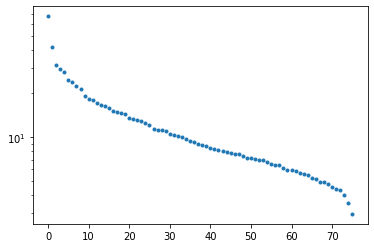

In [7]:
plt.semilogy(range(0, len(S)), S, '.')

### Singular Valuesof embedding entire responses, different outfit responses

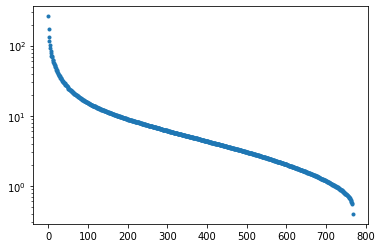

In [8]:
U2, S2, Vt2 = linalg.svd(np.transpose(model.encode(res_separate)))
plt.semilogy(range(0, len(S2)), S2, '.')

### Using longer responses, leaving out short ones, still embedding entire response.

In [9]:
long_res_together = [i for i in res_together if len(i) > 50]

### Same outfit responses

amount of singular values = 51


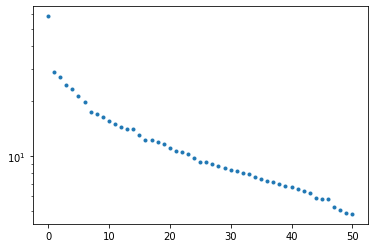

In [10]:
U3, S3, Vt3 = linalg.svd(np.transpose(model.encode(long_res_together)))
plt.semilogy(range(0, len(S3)), S3, '.')
print('amount of singular values = ' + str(len(S3)))

### Different outfit responses

amount of singular values = 643


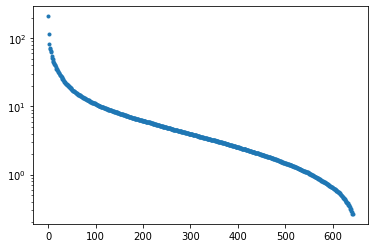

In [11]:
U4, S4, Vt4 = linalg.svd(np.transpose(model.encode([i for i in res_separate if len(i) > 50])))
plt.semilogy(range(0, len(S4)), S4, '.')
print('amount of singular values = ' + str(len(S4)))

### Finding most similar response for the negro survey

In [22]:
no_unclear = [i for i in clean_N if "unclear" not in i]

In [23]:
embed_N = model.encode(no_unclear)

In [36]:
clustering_final = pd.DataFrame({'Entry #': range(0, 769)})

In [48]:
clustering_temp = pd.DataFrame({'Entry #': range(0, len(embed_N)), 'Embed': [i for i in embed_N]})

In [54]:
clustering_temp['Embed'][0][0]

-0.5374851

#### Import necessary library

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

#### Do not rerun

In [85]:
maxes = []
bests = []
for i in range(0, len(clean_N)):
    maxi = 0
    for j in range(0, len(clean_N)):
        if j != i:
            temp = cosine_similarity([embed_N[i]], [embed_N[j]])[0][0]
            if temp > maxi:
                maxi = temp
                index = j
    maxes.append(maxi)
    bests.append(clean_N[index])

(array([   3.,   11.,   43.,  113.,  320.,  881., 1328.,  681.,   50.,
          31.]),
 array([0.32168347, 0.38951513, 0.45734683, 0.5251785 , 0.5930102 ,
        0.6608418 , 0.7286735 , 0.7965052 , 0.8643369 , 0.93216854,
        1.0000002 ], dtype=float32),
 <a list of 10 Patch objects>)

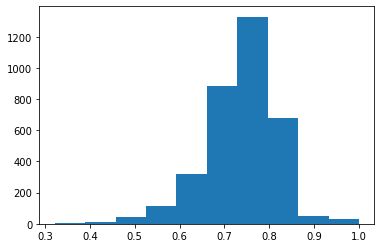

In [88]:
plt.hist(maxes)

In [90]:
approximations = pd.DataFrame({'Response': clean_N, 'Best Approx': bests, 'Similarity': maxes})

In [93]:
approximations.to_csv('32N_approximations.csv')

In [96]:
final = approximations.sort_values(by = 'Similarity', ascending = False)

In [99]:
final.to_csv('32N_approximations_sorted.csv')

### Continue rerunning

In [14]:
from sklearn.cluster import KMeans

## Preparing a dataframe for k means

In [84]:
clustering_final = pd.DataFrame({'entry #': range(1, len(clustering_temp) + 1)})

In [86]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_N)):
        x.append(clustering_temp['Embed'][j][i])
    clustering_final['x' + str(i)] = x

In [88]:
kmeans = KMeans(n_clusters=2).fit(clustering_final.iloc[:, 1:])

In [95]:
prediction = []

In [97]:
for i in kmeans.labels_:
    if i == 1:
        prediction.append('Same outfits')
    else:
        prediction.append('Different outfits')


In [100]:
output = pd.DataFrame({'Response': no_unclear, 'outfit prediction': prediction})

In [102]:
output.to_excel('clustering_32_N.xlsx')